In [1]:
import fastf1
from fastf1 import plotting
from matplotlib import pyplot as plt
import os


In [2]:
folder_name = "/path/to/folder/for/cache"

In [3]:
# Check if the folder already exists
if not os.path.exists(folder_name):
    # Create the folder
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created successfully.")
else:
    print(f"Folder '{folder_name}' already exists.")

Folder '/path/to/folder/for/cache' already exists.


In [6]:
race_2024 = fastf1.get_event_schedule(2024)
plotting.setup_mpl()

fastf1.Cache.enable_cache(folder_name)  # optional but recommended

race = fastf1.get_race(2024, 'Suzuka', 'R')
race.load()

lec = race.laps.pick_driver('BOT')
ham = race.laps.pick_driver('ZHO')

core           INFO 	Loading data for Japanese Grand Prix - Race [v3.3.2]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '4', '14', '63', '81', '44', '22', '27', '18', '20', '77', '31', '10', '2', '24', '3', '23']


In [41]:
import pandas as pd

df = pd.DataFrame(race.laps[['LapTime','Driver']])

# Transforming into DataFrame with a column for unique drivers
unique_drivers = df['Driver'].unique()
unique_drivers.sort()
# Create an empty DataFrame with columns for unique drivers
new_df = {}

# Fill the new DataFrame with lap times for each driver
for driver in unique_drivers:
    new_df[driver] = df.loc[df['Driver'] == driver, 'LapTime'].reset_index(drop=True)
new_df=pd.DataFrame(new_df,columns=unique_drivers)
column_means = new_df.mean()

In [42]:
import plotly.express as px

# Plot con Plotly Express
fig = px.line()
min_mean_columns = column_means.nsmallest(10).index
# Aggiungere tracciati al grafico
for driver in min_mean_columns:
    fig.add_scatter(x=race.laps[race.laps.Driver == driver]['LapNumber'], y=race.laps[race.laps.Driver == driver]['LapTime'], mode='lines', name=driver)

# Aggiungere titolo e label agli assi
fig.update_layout(title='Lap different driver', xaxis_title='Lap Number', yaxis_title='Lap Time')

# Mostrare il grafico
fig.show()

In [97]:
min_mean_columns

Index(['VER', 'PER', 'SAI', 'NOR', 'LEC', 'ALO', 'PIA', 'HAM', 'RUS', 'HUL'], dtype='object')

In [95]:
import plotly.graph_objects as go

min_mean_columns = column_means.nsmallest(10).index
# Creare il boxplot
fig = go.Figure()

for col in min_mean_columns:
    fig.add_trace(go.Box(y=new_df[col][new_df[col] < new_df[col].mean() +  new_df[col].std()], name=col))

# Aggiungere etichette per gli assi e il titolo
fig.update_layout(
    title='Boxplot of Sample Data',
    xaxis=dict(title='Columns'),
    yaxis=dict(title='Values'),
    width=1800,  # Larghezza del grafico in pixel
    height=600  # Altezza del grafico in pixel
)

# Mostrare il boxplot
fig.show()

max_mean_columns = column_means.nlargest(10).index
# Creare il boxplot
fig = go.Figure()

for col in max_mean_columns:
    fig.add_trace(go.Box(y=new_df[col][new_df[col] < new_df[col].mean() +  new_df[col].std()], name=col))

# Aggiungere etichette per gli assi e il titolo
fig.update_layout(
    title='Boxplot of Sample Data',
    xaxis=dict(title='Columns'),
    yaxis=dict(title='Values'),
    width=1800,  # Larghezza del grafico in pixel
    height=600  # Altezza del grafico in pixel
)

# Mostrare il boxplot
fig.show()

['1', '11', '55', '16', '4', '14', '63', '81', '44', '22']
['VER', 'PER', 'SAI', 'LEC', 'NOR', 'ALO', 'RUS', 'PIA', 'HAM', 'TSU']
{'LEC': '#dc0000', 'SAI': '#ff8181', 'SHW': '#9c0000', 'VER': '#fcd700', 'PER': '#ffec7b', 'DEN': '#907400', 'PIA': '#ff8700', 'NOR': '#eeb370', 'OWA': '#ee6d3a', 'GAS': '#fe86bc', 'OCO': '#ff117c', 'DOO': '#894667', 'BOT': '#00e701', 'ZHO': '#008d01', 'POU': '#004601', 'DEV': '#1e3d61', 'TSU': '#356cac', 'RIC': '#2b4562', 'LAW': '#2b4562', 'HAD': '#1e6176', 'MAG': '#ffffff', 'HUL': '#cacaca', 'BEA': '#c40000', 'ALO': '#006f62', 'STR': '#00413b', 'DRU': '#2f9b90', 'HAM': '#00d2be', 'RUS': '#24ffff', 'VES': '#00a6ff', 'ALB': '#005aff', 'SAR': '#012564', 'OSU': '#1b3d97'}


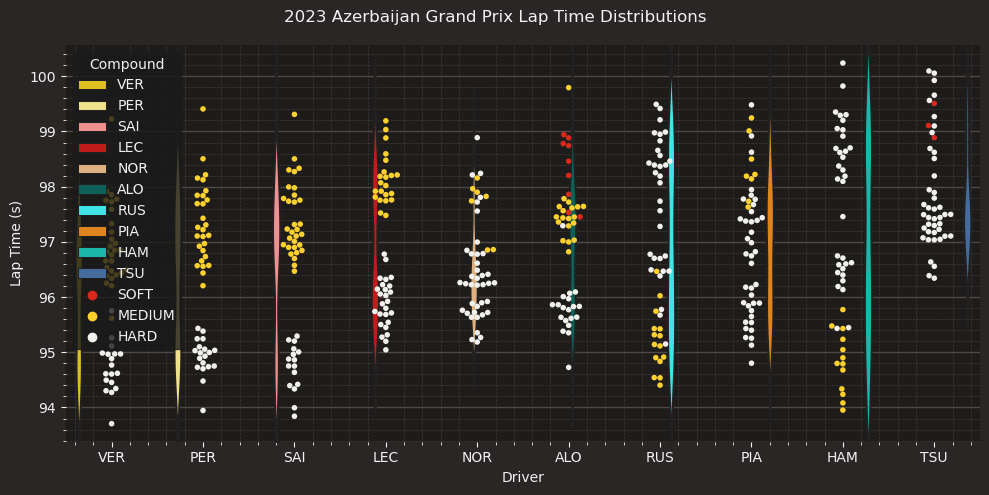

In [48]:
import seaborn as sns

###############################################################################
# Get all the laps for the point finishers only.
# Filter out slow laps (yellow flag, VSC, pitstops etc.)
# as they distort the graph axis.
point_finishers = race.drivers[:10]
print(point_finishers)
driver_laps = race.laps.pick_drivers(point_finishers).pick_quicklaps()
driver_laps = driver_laps.reset_index()

###############################################################################
# To plot the drivers by finishing order,
# we need to get their three-letter abbreviations in the finishing order.
finishing_order = [race.get_driver(i)["Abbreviation"] for i in point_finishers]
print(finishing_order)

###############################################################################
# We need to modify the DRIVER_COLORS palette.
# Its keys are the driver's full names but we need the keys to be the drivers'
# three-letter abbreviations.
# We can do this with the DRIVER_TRANSLATE mapping.
driver_colors = {abv: fastf1.plotting.DRIVER_COLORS[driver] for abv,
                 driver in fastf1.plotting.DRIVER_TRANSLATE.items()}
print(driver_colors)

###############################################################################
# First create the violin plots to show the distributions.
# Then use the swarm plot to show the actual laptimes.

# create the figure
fig, ax = plt.subplots(figsize=(10, 5))

# Seaborn doesn't have proper timedelta support
# so we have to convert timedelta to float (in seconds)
driver_laps["LapTime(s)"] = driver_laps["LapTime"].dt.total_seconds()

sns.violinplot(data=driver_laps,
               x="Driver",
               y="LapTime(s)",
               hue="Driver",
               inner=None,
               density_norm="area",
               order=finishing_order,
               palette=driver_colors
               )

sns.swarmplot(data=driver_laps,
              x="Driver",
              y="LapTime(s)",
              order=finishing_order,
              hue="Compound",
              palette=fastf1.plotting.COMPOUND_COLORS,
              hue_order=["SOFT", "MEDIUM", "HARD"],
              linewidth=0,
              size=4,
              )
# sphinx_gallery_defer_figures

###############################################################################
# Make the plot more aesthetic
ax.set_xlabel("Driver")
ax.set_ylabel("Lap Time (s)")
plt.suptitle("2023 Azerbaijan Grand Prix Lap Time Distributions")
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()


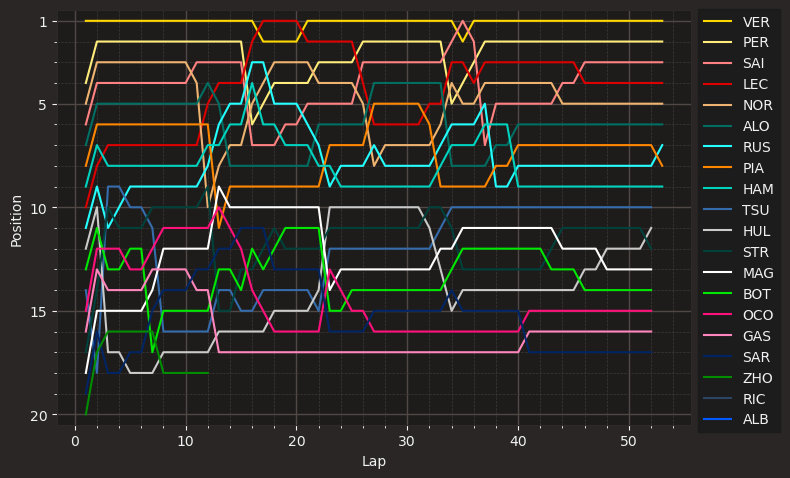

In [50]:

fig, ax = plt.subplots(figsize=(8.0, 4.9))
# sphinx_gallery_defer_figures

##############################################################################
# For each driver, get their three letter abbreviation (e.g. 'HAM') by simply
# using the value of the first lap, get their color and then plot their
# position over the number of laps.
for drv in race.drivers:
    drv_laps = race.laps.pick_driver(drv)

    abb = drv_laps['Driver'].iloc[0]
    color = fastf1.plotting.driver_color(abb)

    ax.plot(drv_laps['LapNumber'], drv_laps['Position'],
            label=abb, color=color)
# sphinx_gallery_defer_figures

##############################################################################
# Finalize the plot by setting y-limits that invert the y-axis so that position
# one is at the top, set custom tick positions and axis labels.
ax.set_ylim([20.5, 0.5])
ax.set_yticks([1, 5, 10, 15, 20])
ax.set_xlabel('Lap')
ax.set_ylabel('Position')
# sphinx_gallery_defer_figures

##############################################################################
# Because this plot is very crowed, add the legend outside the plot area.
ax.legend(bbox_to_anchor=(1.0, 1.02))
plt.tight_layout()

plt.show()

In [94]:
max_mean_columns

Index(['ZHO', 'SAR', 'GAS', 'OCO', 'MAG', 'BOT', 'STR', 'TSU', 'HUL', 'RUS'], dtype='object')

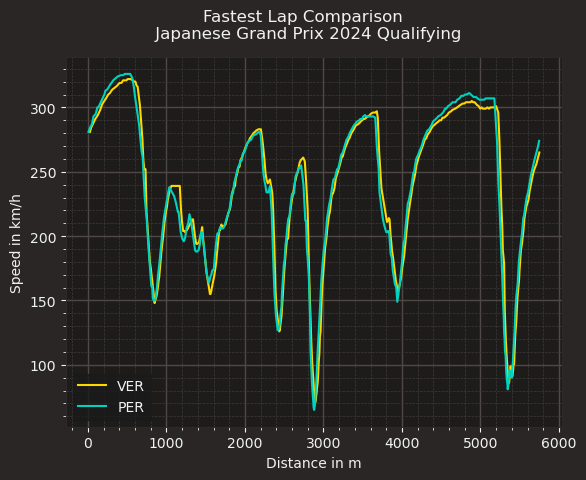

In [98]:
##############################################################################
# First, we select the two laps that we want to compare

ver_lap = race.laps.pick_driver(min_mean_columns[0]).pick_fastest()
ham_lap = race.laps.pick_driver(min_mean_columns[1]).pick_fastest()

##############################################################################
# Next we get the telemetry data for each lap. We also add a 'Distance' column
# to the telemetry dataframe as this makes it easier to compare the laps.

ver_tel = ver_lap.get_car_data().add_distance()
ham_tel = ham_lap.get_car_data().add_distance()

##############################################################################
# Finally, we create a plot and plot both speed traces.
# We color the individual lines with the driver's team colors.

rbr_color = fastf1.plotting.team_color('RBR')
mer_color = fastf1.plotting.team_color('MER')

fig, ax = plt.subplots()
ax.plot(ver_tel['Distance'], ver_tel['Speed'], color=rbr_color, label=min_mean_columns[0])
ax.plot(ham_tel['Distance'], ham_tel['Speed'], color=mer_color, label=min_mean_columns[1])

ax.set_xlabel('Distance in m')
ax.set_ylabel('Speed in km/h')

ax.legend()
plt.suptitle(f"Fastest Lap Comparison \n "
             f"{race.event['EventName']} {race.event.year} Qualifying")

plt.show()

In [84]:
carico_macchina = {}
for name_pil in race.laps.Driver.unique():
    if np.isnan(race.laps.pick_driver(name_pil).pick_fastest().Stint) == False:
        pilota = race.laps.pick_driver(name_pil).pick_fastest().get_car_data().add_distance()
        carico = (pilota['Speed'].mean()/pilota['Speed'].max())*100
        carico_macchina[name_pil] = carico
sorted_carico_macchina = {k: v for k, v in sorted(carico_macchina.items(), key=lambda item: item[1])}

c:\Users\loren\anaconda3\lib\site-packages\fastf1\core.py:3067: FutureWarning:

In the future, `None` will be returned instead of an empty `Lap` object when there are no laps that satisfy the definition for fastest lap.



In [87]:
categorie = list(sorted_carico_macchina.keys())
valori = list(sorted_carico_macchina.values())

# Creare la figura
fig = go.Figure()

# Aggiungere l'istogramma orizzontale
fig.add_trace(go.Bar(
    y=categorie,
    x=valori,
    orientation='h',
    marker_color='skyblue'
))

# Impostare il limite inferiore dell'asse y
fig.update_layout(yaxis=dict(range=[0.5, len(categorie)-0.5]))

# Impostare le etichette e il titolo
fig.update_layout(
    xaxis_title='Valori',
    yaxis_title='Categorie',
    title='Istogramma orizzontale con limite non zero'
)

# Impostare il limite inferiore dell'asse x
fig.update_xaxes(range=[min(valori)-1, max(valori) +1])

# Impostare le dimensioni del grafico
fig.update_layout(
    width=800,  # Larghezza del grafico in pixel
    height=600  # Altezza del grafico in pixel
)


# Mostrare il grafico
fig.show()

In [99]:
import plotly.graph_objects as go
import fastf1

# Definisci i colori delle squadre
rbr_color = fastf1.plotting.team_color('RBR')
mer_color = fastf1.plotting.team_color('MER')

# Crea la figura
fig = go.Figure()

# Aggiungi i tracciati per Verstappen e Hamilton
fig.add_trace(go.Scatter(x=ver_tel['Distance'], y=ver_tel['Speed'], mode='lines', name=min_mean_columns[0], line=dict(color=rbr_color)))
fig.add_trace(go.Scatter(x=ham_tel['Distance'], y=ham_tel['Speed'], mode='lines', name=min_mean_columns[1], line=dict(color=mer_color)))

# Imposta etichette degli assi e titolo
fig.update_xaxes(title_text='Distance in m')
fig.update_yaxes(title_text='Speed in km/h')
fig.update_layout(title=f"Fastest Lap Comparison\n{race.event['EventName']} {race.event.year} Qualifying")

# Mostra la legenda
fig.update_layout(legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01))

# Mostra il grafico
fig.show()

['VER' 'PER' 'SAI' 'LEC' 'NOR' 'ALO' 'RUS' 'PIA' 'HAM' 'TSU' 'HUL' 'STR'
 'MAG' 'BOT' 'OCO' 'GAS' 'SAR' 'ZHO' 'RIC' 'ALB']


c:\Users\loren\anaconda3\lib\site-packages\fastf1\core.py:3067: FutureWarning:

In the future, `None` will be returned instead of an empty `Lap` object when there are no laps that satisfy the definition for fastest lap.



   Driver                LapTime           LapTimeDelta
0     VER 0 days 00:01:33.706000        0 days 00:00:00
1     SAI 0 days 00:01:33.841000 0 days 00:00:00.135000
2     PER 0 days 00:01:33.945000 0 days 00:00:00.239000
3     HAM 0 days 00:01:33.952000 0 days 00:00:00.246000
4     RUS 0 days 00:01:34.404000 0 days 00:00:00.698000
5     ALO 0 days 00:01:34.726000 0 days 00:00:01.020000
6     PIA 0 days 00:01:34.802000 0 days 00:00:01.096000
7     SAR 0 days 00:01:34.900000 0 days 00:00:01.194000
8     LEC 0 days 00:01:35.044000 0 days 00:00:01.338000
9     NOR 0 days 00:01:35.186000 0 days 00:00:01.480000
10    HUL 0 days 00:01:35.325000 0 days 00:00:01.619000
11    STR 0 days 00:01:35.798000 0 days 00:00:02.092000
12    OCO 0 days 00:01:36.232000 0 days 00:00:02.526000
13    TSU 0 days 00:01:36.342000 0 days 00:00:02.636000
14    BOT 0 days 00:01:36.608000 0 days 00:00:02.902000
15    GAS 0 days 00:01:36.642000 0 days 00:00:02.936000
16    MAG 0 days 00:01:36.654000 0 days 00:00:02

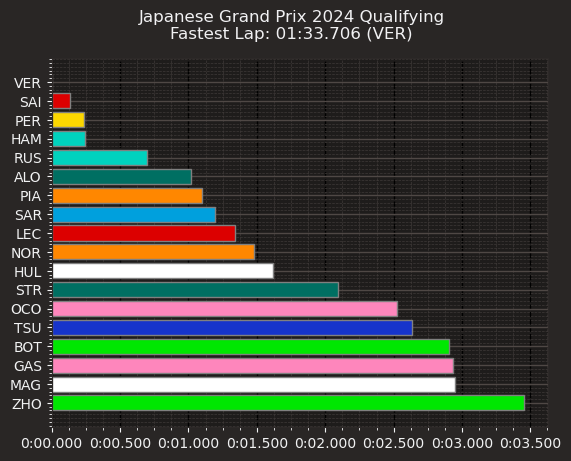

In [104]:
from fastf1.core import Laps
from timple.timedelta import strftimedelta

##############################################################################
# First, we need to get an array of all drivers.

drivers = pd.unique(race.laps['Driver'])
print(drivers)


##############################################################################
# After that we'll get each drivers fastest lap, create a new laps object
# from these laps, sort them by lap time and have pandas reindex them to
# number them nicely by starting position.

list_fastest_laps = list()
for drv in drivers:
    if np.isnan(race.laps.pick_driver(drv).pick_fastest().Stint) == False:
        drvs_fastest_lap = race.laps.pick_driver(drv).pick_fastest()
        list_fastest_laps.append(drvs_fastest_lap)
    fastest_laps = Laps(list_fastest_laps) \
        .sort_values(by='LapTime') \
        .reset_index(drop=True)


##############################################################################
# The plot is nicer to look at and more easily understandable if we just plot
# the time differences. Therefore we subtract the fastest lap time from all
# other lap times.

pole_lap = fastest_laps.pick_fastest()
fastest_laps['LapTimeDelta'] = fastest_laps['LapTime'] - pole_lap['LapTime']
##############################################################################
# We can take a quick look at the laps we have to check if everything
# looks all right. For this, we'll just check the 'Driver', 'LapTime'
# and 'LapTimeDelta' columns.

print(fastest_laps[['Driver', 'LapTime', 'LapTimeDelta']])


##############################################################################
# Finally, we'll create a list of team colors per lap to color our plot.
team_colors = list()
for index, lap in fastest_laps.iterlaps():
    color = fastf1.plotting.team_color(lap['Team'])
    team_colors.append(color)


##############################################################################
# Now, we can plot all the data
fig, ax = plt.subplots()
ax.barh(fastest_laps.index, fastest_laps['LapTimeDelta'],
        color=team_colors, edgecolor='grey')
ax.set_yticks(fastest_laps.index)
ax.set_yticklabels(fastest_laps['Driver'])

# show fastest at the top
ax.invert_yaxis()

# draw vertical lines behind the bars
ax.set_axisbelow(True)
ax.xaxis.grid(True, which='major', linestyle='--', color='black', zorder=-1000)
# sphinx_gallery_defer_figures


##############################################################################
# Finally, give the plot a meaningful title

lap_time_string = strftimedelta(pole_lap['LapTime'], '%m:%s.%ms')

plt.suptitle(f"{race.event['EventName']} {race.event.year} Qualifying\n"
             f"Fastest Lap: {lap_time_string} ({pole_lap['Driver']})")

plt.show()

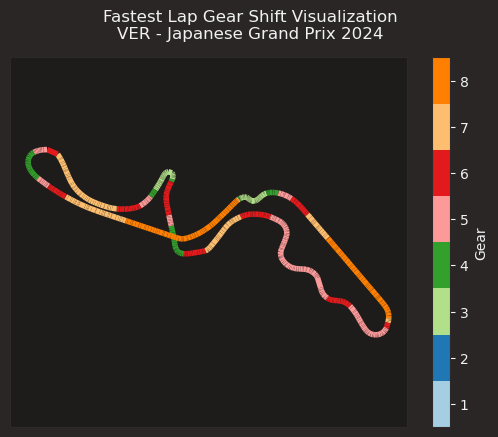

In [110]:
from matplotlib import colormaps
from matplotlib.collections import LineCollection

lap = race.laps.pick_fastest()
tel = lap.get_telemetry()
# sphinx_gallery_defer_figures
##############################################################################
# Prepare the data for plotting by converting it to the appropriate numpy
# data types

x = np.array(tel['X'].values)
y = np.array(tel['Y'].values)

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
gear = tel['nGear'].to_numpy().astype(float)
# sphinx_gallery_defer_figures

##############################################################################
# Create a line collection. Set a segmented colormap and normalize the plot
# to full integer values of the colormap

cmap = colormaps['Paired']
lc_comp = LineCollection(segments, norm=plt.Normalize(1, cmap.N+1), cmap=cmap)
lc_comp.set_array(gear)
lc_comp.set_linewidth(4)
# sphinx_gallery_defer_figures

##############################################################################
# Create the plot

plt.gca().add_collection(lc_comp)
plt.axis('equal')
plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)

title = plt.suptitle(
    f"Fastest Lap Gear Shift Visualization\n"
    f"{lap['Driver']} - {race.event['EventName']} {race.event.year}"
)
# sphinx_gallery_defer_figures


##############################################################################
# Add a colorbar to the plot. Shift the colorbar ticks by +0.5 so that they
# are centered for each color segment.

cbar = plt.colorbar(mappable=lc_comp, label="Gear",
                    boundaries=np.arange(1, 10))
cbar.set_ticks(np.arange(1.5, 9.5))
cbar.set_ticklabels(np.arange(1, 9))


plt.show()

In [107]:
lc_comp